In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from object_loc_helper import get_simple_model_V2, GeneratorMultipleOutputsV2, iou, get_class_names_map, getIUO, get_VGG16_V2
import numpy as np

Using TensorFlow backend.


In [3]:
synset_dict = get_class_names_map()

In [4]:
reduced_dataset_folder = 'dataset_5_classes_plus_world'

In [5]:
# Carpetas donde estan las imagenes
train_folder = reduced_dataset_folder+ '/images/train'
val_folder = reduced_dataset_folder+ '/images/val'

In [6]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [7]:

#model = get_simple_model_V2()
model = get_VGG16_V2()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 375, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 375, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 187, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [17]:
#5_classes_iou_do_0.25_Adam_0.0001
#concat_0.001
#more_images_concat_0.0001
model.load_weights('runtime_best-002.hdf5')

In [18]:
from custom_losses import custom_loss, classes_acc, confidence_acc, bounding_box_mse, iou_v2
from object_loc_helper import getIUO

In [19]:
losses = {"concatenated_outputs": custom_loss}
lossWeights = {"concatenated_outputs": 1.0}
metrics = {"concatenated_outputs": [classes_acc, confidence_acc, bounding_box_mse, iou_v2]}

In [20]:
model.compile(metrics=metrics, optimizer='Adam', loss=losses)

In [21]:
#train_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_train, 
# train_folder, 64, flip='never')
val_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_val, 
                                                            val_folder, 
                                                            33, 
                                                            flip='never')

Found 259 images belonging to 6 classes.


In [22]:
val_metrics = model.evaluate_generator(val_generator_multiple_outputs, verbose=1)
print(val_metrics)
print('Validation Classification Acc:', val_metrics[1])
print('Validation IOU:', val_metrics[4])
print('Confidence:', val_metrics[2])

8/8 [==============================] - 3s 372ms/step
[0.20688819343001225, 0.9847104241028716, 0.9266409340052071, 0.012208841124398483, 0.6361281054820793]
Validation Classification Acc: 0.9847104241028716
Validation IOU: 0.6361281054820793
Confidence: 0.9266409340052071


In [14]:
val_metrics = model.evaluate_generator(val_generator_multiple_outputs, verbose=1)
print(val_metrics)
print('Validation Classification Acc:', val_metrics[1])
print('Validation IOU:', val_metrics[4])
print('Confidence:', val_metrics[2])

8/8 [==============================] - 6s 717ms/step
[0.19347172436164153, 0.9847104241028716, 0.9382239497306264, 0.012027429655899067, 0.6303293334471213]
Validation Classification Acc: 0.9847104241028716
Validation IOU: 0.6303293334471213
Confidence: 0.9382239497306264


In [15]:
index_2_class = {v:k for k,v in val_generator_multiple_outputs.generator.class_indices.items()}

In [16]:
index_2_class

{0: 'n01751748',
 1: 'n02108089',
 2: 'n02279972',
 3: 'n02701002',
 4: 'n04487081',
 5: 'world'}

In [17]:
n_classes = 5
val_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_val, 
                                                            val_folder, 
                                                            32, 
                                                            flip='never')
total_count = 0
not_world_count = 0
confidence_total_count = 0
accuracy_total_count = 0
total_iou = 0
confidence_error_images = []
confidence_error_accs = []

for i, batch in enumerate(val_generator_multiple_outputs):
    total_count = total_count + batch[1].shape[0]
    prediction = model.predict_on_batch(batch[0])
    confidence_count_indexes = (batch[1][:,-1] == 1*(prediction[:,-1]>0.5))
    errors_indexes = np.array(np.logical_not(confidence_count_indexes))
    for k, image in enumerate(batch[0][errors_indexes]):
        confidence_error_images.append(image)
        if batch[1][errors_indexes][k][:n_classes].sum() == 0:
            original_class = 'world'
        else:
            original_class = synset_dict[index_2_class[np.argmax(batch[1][errors_indexes][k][:n_classes])]]
        confidence_error_accs.append(
            {
                'confidence': prediction[errors_indexes][k][-1],
                'predicted_class': synset_dict[index_2_class[np.argmax(prediction[errors_indexes][k][:n_classes])]],
                'original_class': original_class,
                'predicted_bounding_box': prediction[errors_indexes][k][n_classes:n_classes+4]
            }
        )
    confidence_total_count = confidence_total_count + confidence_count_indexes.sum()
    pos_indexes = batch[1][:,-1] == 1
    not_world_count = not_world_count + pos_indexes.sum()
    accuracy_total_count = accuracy_total_count + (np.argmax(batch[1][pos_indexes,:n_classes], axis = 1) == np.argmax(prediction[pos_indexes,:n_classes], axis = 1)).sum()
    total_iou = total_iou + getIUO(batch[1][pos_indexes,n_classes:n_classes+4], 
                    prediction[pos_indexes,n_classes:n_classes+4],
                    from_center_to_box = True
                   )[0].sum()
    if i == len(val_generator_multiple_outputs)-1:
        break
print(total_count, 
      confidence_total_count/total_count, 
      accuracy_total_count/not_world_count, 
      total_iou/not_world_count)

Found 259 images belonging to 6 classes.
259 0.9382239382239382 0.9856459330143541 0.6318172973003016


total: 16
{'confidence': 0.8409875, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.44700637, 0.49359375, 0.7351693 , 0.55858433], dtype=float32)}


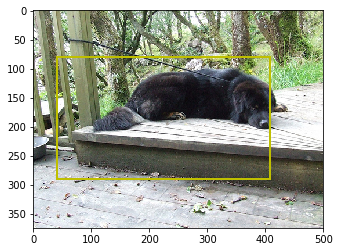

{'confidence': 0.5092512, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.4769479 , 0.48664808, 0.6161972 , 0.7281926 ], dtype=float32)}


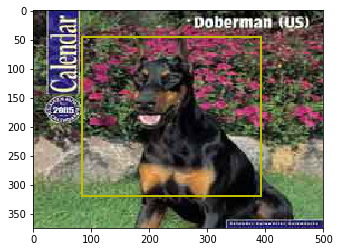

{'confidence': 0.37417257, 'predicted_class': 'boxer', 'original_class': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'predicted_bounding_box': array([0.49348122, 0.42954242, 0.56446385, 0.50260746], dtype=float32)}


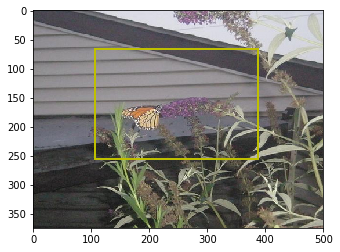

{'confidence': 0.69048494, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.4776277 , 0.61501205, 0.6332711 , 0.49928713], dtype=float32)}


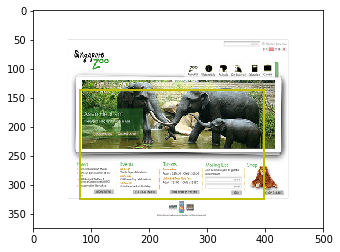

{'confidence': 0.9029373, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.49041057, 0.49165583, 0.67540294, 0.64124763], dtype=float32)}


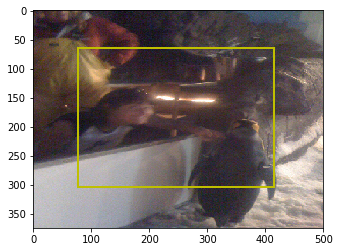

{'confidence': 0.57523006, 'predicted_class': 'sea snake', 'original_class': 'world', 'predicted_bounding_box': array([0.47767818, 0.50071347, 0.47290647, 0.43715018], dtype=float32)}


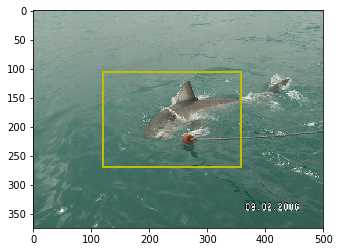

{'confidence': 0.606517, 'predicted_class': 'sea snake', 'original_class': 'world', 'predicted_bounding_box': array([0.47947225, 0.5058013 , 0.51098996, 0.49807698], dtype=float32)}


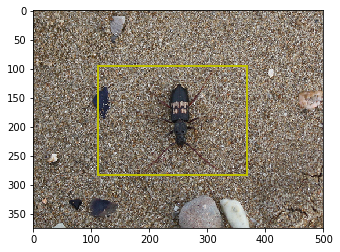

{'confidence': 0.16576795, 'predicted_class': 'boxer', 'original_class': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'predicted_bounding_box': array([0.52031916, 0.49352807, 0.61196125, 0.6598377 ], dtype=float32)}


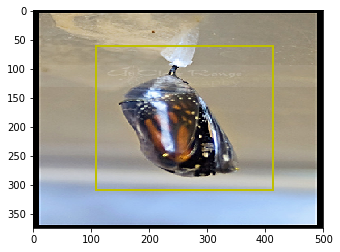

{'confidence': 0.91124016, 'predicted_class': 'sea snake', 'original_class': 'world', 'predicted_bounding_box': array([0.5126406 , 0.48795995, 0.5357406 , 0.4137757 ], dtype=float32)}


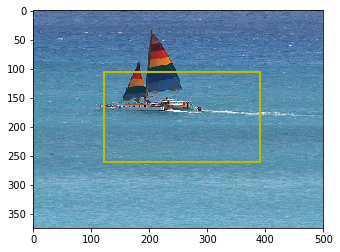

{'confidence': 0.24208644, 'predicted_class': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'original_class': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'predicted_bounding_box': array([0.4984353, 0.5035452, 0.4330079, 0.5061282], dtype=float32)}


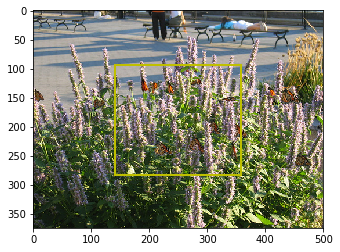

{'confidence': 0.9876996, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.47646013, 0.5158535 , 0.76663077, 0.7258416 ], dtype=float32)}


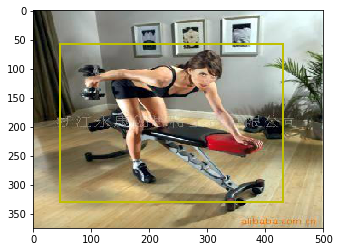

{'confidence': 0.4045064, 'predicted_class': 'ambulance', 'original_class': 'ambulance', 'predicted_bounding_box': array([0.53476655, 0.53617823, 0.7288889 , 0.88655925], dtype=float32)}


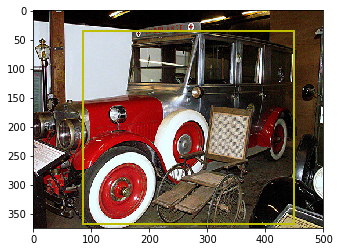

{'confidence': 0.32985818, 'predicted_class': 'sea snake', 'original_class': 'sea snake', 'predicted_bounding_box': array([0.45068857, 0.4511789 , 0.4904058 , 0.55487216], dtype=float32)}


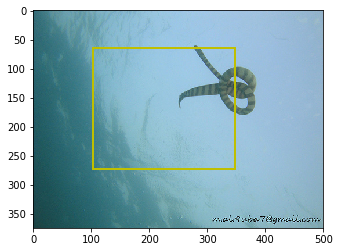

{'confidence': 0.5983218, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.46481755, 0.5024502 , 0.7673559 , 0.7938417 ], dtype=float32)}


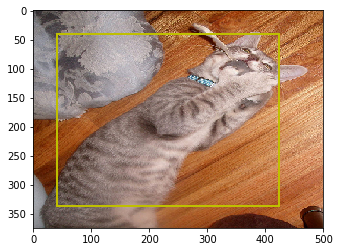

{'confidence': 0.91132003, 'predicted_class': 'boxer', 'original_class': 'world', 'predicted_bounding_box': array([0.48703593, 0.6026229 , 0.57518625, 0.639686  ], dtype=float32)}


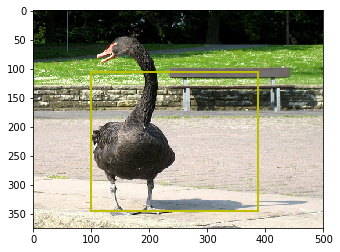

{'confidence': 0.45449546, 'predicted_class': 'boxer', 'original_class': 'boxer', 'predicted_bounding_box': array([0.47210157, 0.51660395, 0.5374813 , 0.5813519 ], dtype=float32)}


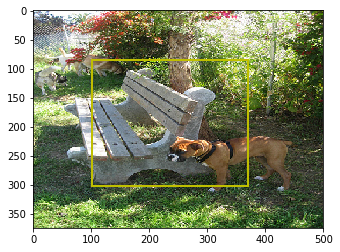

In [18]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
print('total:', len(confidence_error_images))
for i, image in enumerate(confidence_error_images):
    print(confidence_error_accs[i])
    f, ax = plt.subplots(1,1)
    ax.imshow(image)
    im_w = image.shape[1]
    im_h = image.shape[0]
    bounding_box = confidence_error_accs[i]['predicted_bounding_box']
    centerX = bounding_box[0]
    width = bounding_box[2]
    centerY = bounding_box[1]
    height = bounding_box[3]
    predicted_bounding_box = [((centerX-width/2)*im_w), ((centerY-height/2)*im_h), ((centerX+width/2)*im_w), ((centerY+height/2)*im_h)]
    rect = patches.Rectangle(predicted_bounding_box[:2],
                                predicted_bounding_box[2]-predicted_bounding_box[0],
                                predicted_bounding_box[3]-predicted_bounding_box[1],
                                linewidth=2, edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [20]:
data_to_predict = next(val_generator_multiple_outputs)
images_batch = data_to_predict[0]
predictions_batch = model.predict_on_batch(images_batch)

In [21]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [38]:
predictions_batch[:,n_classes:n_classes+4].shape

(32, 4)

In [34]:
data_to_predict[1][:,n_classes:n_classes+4].shape

(32, 4)

In [40]:
# Todas las bounding boxes a formato de cuadrado
bounding_boxes_norm = data_to_predict[1][:,n_classes:n_classes+4]
bounding_boxes = np.array([
    bounding_boxes_norm[:,0] - bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] - bounding_boxes_norm[:,3]/2,
 bounding_boxes_norm[:,0] + bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] + bounding_boxes_norm[:,3]/2,]).T

bounding_boxes_norm_pred = predictions_batch[:,n_classes:n_classes+4]
bounding_boxes_pred = np.array([
    bounding_boxes_norm_pred[:,0] - bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] - bounding_boxes_norm_pred[:,3]/2,
 bounding_boxes_norm_pred[:,0] + bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] + bounding_boxes_norm_pred[:,3]/2,]).T

In [41]:
IOUs, inters_bb = getIUO(bounding_boxes, bounding_boxes_pred)
zero_iou_indexes = np.where(IOUs==0)

0


IndexError: tuple index out of range

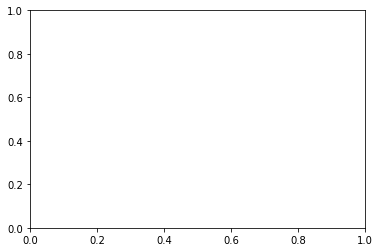

In [43]:
#for i in zero_iou_indexes[0]:
for i in range(10):
    f, ax = plt.subplots(1,1)
    prediction_index = i # + 30
    print(i)
    predicted_class_name = synset_dict[index_2_class[np.argmax(predictions_batch[0][prediction_index])]]
    ground_truth_class_id = data_to_predict[2][prediction_index].split('/')[0]
    filename = data_to_predict[2][prediction_index].split('/')[1]
    ground_truth_class_name = synset_dict[ground_truth_class_id]
    print('Pred class: ', predicted_class_name)
    print('Grund Truph:',ground_truth_class_name)
    bounding_box = annotations_dict_val[ground_truth_class_id][filename.split('.')[0]]['bounding_boxes'][0]
    im_w = images_batch[prediction_index].shape[1]
    im_h = images_batch[prediction_index].shape[0]
    centerX = predictions_batch[1][prediction_index][0]
    centerY = predictions_batch[1][prediction_index][1]
    width = predictions_batch[1][prediction_index][2]
    height = predictions_batch[1][prediction_index][3]
    
    predicted_bounding_box = [((centerX-width/2)*im_w), ((centerY-height/2)*im_h), ((centerX+width/2)*im_w), ((centerY+height/2)*im_h)]
    ax.imshow(images_batch[prediction_index])
    ax.scatter(centerX*im_w, centerY*im_h, s= 50)
    rect = patches.Rectangle(predicted_bounding_box[:2],
                                predicted_bounding_box[2]-predicted_bounding_box[0],
                                predicted_bounding_box[3]-predicted_bounding_box[1],
                                linewidth=2, edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    rect_gt = patches.Rectangle(bounding_box[:2],
                                bounding_box[2]-bounding_box[0],
                                bounding_box[3]-bounding_box[1],
                                linewidth=2, edgecolor='r',facecolor='none')
    ax.add_patch(rect_gt)
    IOU, intersection_bb = getIUO(np.array([predicted_bounding_box]), np.array([bounding_box]))
    intersection_bb = intersection_bb[0]
    rect_int = patches.Rectangle(intersection_bb[:2],
                                intersection_bb[2]-intersection_bb[0],
                                intersection_bb[3]-intersection_bb[1],
                                linewidth=2, edgecolor='b',facecolor='none')
    ax.add_patch(rect_int)
    
    print('IOU:',IOU)
    plt.show()